<center><h2>ALTeGraD 2023<br>Lab Session 1: NMT</h2><h3> Neural Machine Translation</h3> 10 / 10 / 2023<br> Dr. G. Shang and H. Abdine</center>

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from nltk import word_tokenize

## Define the Encoder / Task 1

In [13]:
class Encoder(nn.Module):
    '''
    to be passed the entire source sequence at once
    we use padding_idx in nn.Embedding so that the padding vector does not take gradient (always zero)
    https://pytorch.org/docs/stable/nn.html#gru
    '''
    def __init__(self, vocab_size, embedding_dim, hidden_dim, padding_idx):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim)

    def forward(self, input):
        # fill the gaps # (transform input into embeddings and pass embeddings to RNN)
        # you should return a tensor of shape (seq, batch, feat)
        emb_input = self.embedding(input) #output shape = (seq_length, batch_size, embedding_dim)
        hs, _ = self.rnn(emb_input) # output shape = (seq_length, batch_size, hidden_dim)
        return hs

## Define the Attention layer / Task 3

In [14]:
class seq2seqAtt(nn.Module):
    '''
    concat global attention a la Luong et al. 2015 (subsection 3.1)
    https://arxiv.org/pdf/1508.04025.pdf
    '''
    def __init__(self, hidden_dim, hidden_dim_s, hidden_dim_t):
        super(seq2seqAtt, self).__init__()
        self.ff_concat = nn.Linear(hidden_dim_s+hidden_dim_t, hidden_dim)
        self.ff_score = nn.Linear(hidden_dim, 1, bias=False) # just a dot product here

    def forward(self, target_h, source_hs):
        target_h_rep = target_h.repeat(source_hs.size(0), 1, 1) # (1, batch, feat) -> (seq, batch, feat)
        # fill the gaps #
        # implement the score computation part of the concat formulation (see section 3.1. of Luong 2015)
        concat_output = torch.tanh((self.ff_concat(torch.concatenate((target_h_rep, source_hs), dim = 2)))) #dim=(seq, batch,hidden_dim_s+hidden_dim_t)
        scores = self.ff_score(concat_output)# should be of shape (seq, batch, 1)
        scores = scores.squeeze(dim=2) # (seq, batch, 1) -> (seq, batch). dim = 2 because we don't want to squeeze the batch dim if batch size = 1
        norm_scores = torch.softmax(scores, 0)
        source_hs_p = source_hs.permute((2, 0, 1)) # (seq, batch, feat) -> (feat, seq, batch)
        weighted_source_hs = (norm_scores * source_hs_p) # (seq, batch) * (feat, seq, batch) (* checks from right to left that the dimensions match)
        ct = torch.sum(weighted_source_hs.permute((1, 2, 0)), 0, keepdim=True) # (feat, seq, batch) -> (seq, batch, feat) -> (1, batch, feat); keepdim otherwise sum squeezes
        return ct, norm_scores

## Define the Decoder layer / Task 2

In [15]:
class Decoder(nn.Module):
    '''to be used one timestep at a time
       see https://pytorch.org/docs/stable/nn.html#gru'''
    def __init__(self, vocab_size, embedding_dim, hidden_dim, padding_idx):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim)
        self.ff_concat = nn.Linear(2*hidden_dim, hidden_dim)
        self.predict = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, source_context, h):
        # fill the gaps #
        # transform input into embeddings, pass embeddings to RNN, concatenate with source_context and apply tanh, and make the prediction
        # prediction should be of shape (1, batch, vocab), h and tilde_h of shape (1, batch, feat)

        emb_input = self.embedding(input) #output shape = (seq_length, batch_size, embedding_dim)

        _, h = self.rnn(emb_input, h) #output shape = (1, batch_size, hidden_dim)

        concatenated_vector = torch.concatenate((source_context, h), dim = 2) #dim = (1, batch_size, hidden_dim*2)
        tilde_h = torch.tanh(self.ff_concat(concatenated_vector)) #shape = (1, batch_size, hidden_dim)
        prediction = self.predict(tilde_h)

        return prediction, h

# Define the full seq2seq model / Task 4:

In [16]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import numpy as np

In [17]:
class seq2seqModel(nn.Module):
    '''the full seq2seq model'''
    ARGS = ['vocab_s','source_language','vocab_t_inv','embedding_dim_s','embedding_dim_t',
     'hidden_dim_s','hidden_dim_t','hidden_dim_att','do_att','padding_token',
     'oov_token','sos_token','eos_token','max_size']
    def __init__(self, vocab_s, source_language, vocab_t_inv, embedding_dim_s, embedding_dim_t,
                 hidden_dim_s, hidden_dim_t, hidden_dim_att, do_att, padding_token,
                 oov_token, sos_token, eos_token, max_size):
        super(seq2seqModel, self).__init__()
        self.vocab_s = vocab_s
        self.source_language = source_language
        self.vocab_t_inv = vocab_t_inv
        self.embedding_dim_s = embedding_dim_s
        self.embedding_dim_t = embedding_dim_t
        self.hidden_dim_s = hidden_dim_s
        self.hidden_dim_t = hidden_dim_t
        self.hidden_dim_att = hidden_dim_att
        self.do_att = do_att # should attention be used?
        self.padding_token = padding_token
        self.oov_token = oov_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.max_size = max_size

        self.max_source_idx = max(list(vocab_s.values()))
        print('max source index',self.max_source_idx)
        print('source vocab size',len(vocab_s))

        self.max_target_idx = max([int(elt) for elt in list(vocab_t_inv.keys())])
        print('max target index',self.max_target_idx)
        print('target vocab size',len(vocab_t_inv))
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encoder = Encoder(self.max_source_idx+1, self.embedding_dim_s, self.hidden_dim_s, self.padding_token).to(self.device)
        self.decoder = Decoder(self.max_target_idx+1, self.embedding_dim_t, self.hidden_dim_t, self.padding_token).to(self.device)

        if self.do_att:
            self.att_mech = seq2seqAtt(self.hidden_dim_att, self.hidden_dim_s, self.hidden_dim_t).to(self.device)

    def my_pad(self, my_list):
        '''my_list is a list of tuples of the form [(tensor_s_1, tensor_t_1), ..., (tensor_s_batch, tensor_t_batch)]
        the <eos> token is appended to each sequence before padding
        https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pad_sequence'''
        batch_source = pad_sequence([torch.cat((elt[0], torch.LongTensor([self.eos_token]))) for elt in my_list], batch_first=True, padding_value=self.padding_token)
        batch_target = pad_sequence([torch.cat((elt[1], torch.LongTensor([self.eos_token]))) for elt in my_list], batch_first=True, padding_value=self.padding_token)
        return batch_source, batch_target

    def forward(self, input, max_size, is_prod):
        if is_prod:
            input = input.unsqueeze(1) # (seq) -> (seq, 1) 1D input <=> we receive just one sentence as input (predict/production mode)
        current_batch_size = input.size(1)
        # fill the gap #
        # use the encoder
        source_hs =  self.encoder(input)
        # = = = decoder part (one timestep at a time)  = = =
        target_h = torch.zeros(size=(1, current_batch_size, self.hidden_dim_t)).to(self.device) # init (1, batch, feat)

        # fill the gap #
        # (initialize target_input with the proper token)
        target_input = torch.LongTensor([self.sos_token]).repeat(current_batch_size).unsqueeze(0).to(self.device) # init (1, batch)
        pos = 0
        eos_counter = 0
        logits = []
        scores = []

        while True:
            if self.do_att:
                source_context, score = self.att_mech(target_h, source_hs) # (1, batch, feat)
                scores.append(score.squeeze().cpu().detach().numpy())
            else:
                source_context = source_hs[-1, :, :].unsqueeze(0) # (1, batch, feat) last hidden state of encoder
            # fill the gap #
            # use the decoder
            prediction, target_h = self.decoder(target_input,source_context,target_h)
            logits.append(prediction) # (1, batch, vocab)
            # fill the gap #
            # get the next input to pass the decoder
            target_input = torch.argmax(prediction, dim=2)# the predicted word
            eos_counter += torch.sum(target_input==self.eos_token).item()
            pos += 1
            if pos >= max_size or (eos_counter == current_batch_size and is_prod):
                break
        to_return = torch.cat(logits, 0) # logits is a list of tensors -> (seq, batch, vocab)

        if is_prod:
            to_return = to_return.squeeze(dim=1) # (seq, vocab)

        return to_return, scores

    def fit(self, trainingDataset, testDataset, lr, batch_size, n_epochs, patience):
        parameters = [p for p in self.parameters() if p.requires_grad]
        optimizer = optim.Adam(parameters, lr=lr)
        criterion = torch.nn.CrossEntropyLoss(ignore_index=self.padding_token) # the softmax is inside the loss!
        # https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
        # we pass a collate function to perform padding on the fly, within each batch
        # this is better than truncation/padding at the dataset level
        train_loader = data.DataLoader(trainingDataset, batch_size=batch_size,
                                       shuffle=True, collate_fn=self.my_pad) # returns (batch, seq)
        test_loader = data.DataLoader(testDataset, batch_size=512,
                                      collate_fn=self.my_pad)
        tdqm_dict_keys = ['loss', 'test loss']
        tdqm_dict = dict(zip(tdqm_dict_keys, [0.0, 0.0]))
        patience_counter = 1
        patience_loss = 99999

        for epoch in range(n_epochs):
            with tqdm(total=len(train_loader), unit_scale=True, postfix={'loss':0.0, 'test loss':0.0},
                      desc="Epoch : %i/%i" % (epoch, n_epochs-1), ncols=100) as pbar:
                for loader_idx, loader in enumerate([train_loader, test_loader]):
                    total_loss = 0
                    # set model mode (https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
                    if loader_idx == 0:
                        self.train()
                    else:
                        self.eval()
                    for i, (batch_source, batch_target) in enumerate(loader):
                        batch_source = batch_source.transpose(1, 0).to(self.device) # RNN needs (seq, batch, feat) but loader returns (batch, seq)
                        batch_target = batch_target.transpose(1, 0).to(self.device) # (seq, batch)

                        # are we using the model in production
                        is_prod = len(batch_source.shape)==1 # if False, 2D input (seq, batch), i.e., train or test
                        if is_prod:
                            max_size = self.max_size
                            self.eval()
                        else:
                            max_size = batch_target.size(0) # no need to continue generating after we've exceeded the length of the longest ground truth sequence

                        unnormalized_logits,_ = self.forward(batch_source, max_size, is_prod)
                        sentence_loss = criterion(unnormalized_logits.flatten(end_dim=1), batch_target.flatten())
                        total_loss += sentence_loss.item()
                        tdqm_dict[tdqm_dict_keys[loader_idx]] = total_loss/(i+1)
                        pbar.set_postfix(tdqm_dict)
                        if loader_idx == 0:
                            optimizer.zero_grad() # flush gradient attributes
                            sentence_loss.backward() # compute gradients
                            optimizer.step() # update
                            pbar.update(1)

            if total_loss > patience_loss:
                patience_counter += 1
            else:
                patience_loss = total_loss
                patience_counter = 1 # reset

            if patience_counter > patience:
                break

    def sourceNl_to_ints(self, source_nl):
        '''converts natural language source sentence into source integers'''
        source_nl_clean = source_nl.lower().replace("'",' ').replace('-',' ')
        source_nl_clean_tok = word_tokenize(source_nl_clean, self.source_language)
        source_ints = [int(self.vocab_s[elt]) if elt in self.vocab_s else \
                       self.oov_token for elt in source_nl_clean_tok]

        source_ints = torch.LongTensor(source_ints).to(self.device)
        return source_ints

    def targetInts_to_nl(self, target_ints):
        '''converts integer target sentence into target natural language'''
        return ['<PAD>' if elt==self.padding_token else '<OOV>' if elt==self.oov_token \
                else '<EOS>' if elt==self.eos_token else '<SOS>' if elt==self.sos_token\
                else self.vocab_t_inv[elt] for elt in target_ints]

    def predict(self, source_nl):
        source_ints = self.sourceNl_to_ints(source_nl)
        logits, _ = self.forward(source_ints, self.max_size, True) # (seq) -> (<=max_size, vocab)
        target_ints = logits.argmax(-1).squeeze() # (<=max_size, 1) -> (<=max_size)
        target_nl = self.targetInts_to_nl(target_ints.tolist())
        return ' '.join(target_nl)

    def save(self, path_to_file):
        attrs = {attr:getattr(self,attr) for attr in self.ARGS}
        attrs['state_dict'] = self.state_dict()
        torch.save(attrs, path_to_file)

    def attention_viz(self, source_nl):

        source_ints = self.sourceNl_to_ints(source_nl)
        logits, scores = self.forward(source_ints, self.max_size, True)
        target_ints = logits.argmax(-1).squeeze()
        target_nl = self.targetInts_to_nl(target_ints.tolist())

        font = {'size': 10}

        plt.rc('font', **font)
        plt.rcParams['font.family'] = 'sans-serif'  # Utilisez une police sans-serif

        figure = plt.figure()
        subplot = figure.add_subplot(111)
        heatmap = subplot.matshow(np.array(scores[:10]), cmap="cividis")
        figure.colorbar(heatmap)
        words  = source_nl.split()
        subplot.set_xticklabels([''] + [x for x in words])
        subplot.set_yticklabels([''] + [x for x in target_nl])
        subplot.xaxis.set_major_locator(ticker.MultipleLocator(1))
        subplot.yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.show()

        return




    @classmethod # a class method does not see the inside of the class (a static method does not take self as first argument)
    def load(cls, path_to_file):
        attrs = torch.load(path_to_file, map_location=lambda storage, loc: storage) # allows loading on CPU a model trained on GPU, see https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349/6
        state_dict = attrs.pop('state_dict')
        new = cls(**attrs) # * list and ** names (dict) see args and kwargs
        new.load_state_dict(state_dict)
        return new

In [18]:
import sys
import json

import torch
from torch.utils import data

## Prepare the Data:

In [19]:
### you can download the data from Moodle and upload them to Colab (data.zip and pretrained_moodle.pt)
!wget -c "https://uc58b5136370605959a0591d349b.dl.dropboxusercontent.com/cd/0/get/CFWn2mJjQdsdDWDldtVpdMcjkv9U-DCRDkPKVehapwI31NzS4iho7LnNgsvjkGCXzJYvQI4lFq-SWIgRlNHajTFKPlNfsm7zHsk6hb3Q0BO8QhkARmRNHhBq6yNbqSRj-7RR2jHy8Tgt7fNdN_sGlR7N79FP31zOckzBEYaVWizEEg/file#" -O "data.zip"
!wget -c "https://uc5de1b70fa0a20a0c1573f89d75.dl.dropboxusercontent.com/cd/0/get/CFV5KewBNO-O3_eTXY9EszmkCLJOfYxKlyXOtp1N0oHcYYxP8fhd-63BJiA0cXEpsL9vBlpaMjI0OQno4uyuduNkAji5AHTya686hf-dpxwTC--gAeYylgKqn6zFq_ubcUw3EYfID4S4JlIJVqFV7AgPHwTcLsXJT3PcuxGwCE1ljQ/file#" -O "pretrained_moodle.pt"
!unzip data.zip

path_to_data = './data/'
path_to_save_models = './'

--2023-10-17 20:30:37--  https://uc58b5136370605959a0591d349b.dl.dropboxusercontent.com/cd/0/get/CFWn2mJjQdsdDWDldtVpdMcjkv9U-DCRDkPKVehapwI31NzS4iho7LnNgsvjkGCXzJYvQI4lFq-SWIgRlNHajTFKPlNfsm7zHsk6hb3Q0BO8QhkARmRNHhBq6yNbqSRj-7RR2jHy8Tgt7fNdN_sGlR7N79FP31zOckzBEYaVWizEEg/file
Resolving uc58b5136370605959a0591d349b.dl.dropboxusercontent.com (uc58b5136370605959a0591d349b.dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to uc58b5136370605959a0591d349b.dl.dropboxusercontent.com (uc58b5136370605959a0591d349b.dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-10-17 20:30:37 ERROR 404: Not Found.

--2023-10-17 20:30:37--  https://uc5de1b70fa0a20a0c1573f89d75.dl.dropboxusercontent.com/cd/0/get/CFV5KewBNO-O3_eTXY9EszmkCLJOfYxKlyXOtp1N0oHcYYxP8fhd-63BJiA0cXEpsL9vBlpaMjI0OQno4uyuduNkAji5AHTya686hf-dpxwTC--gAeYylgKqn6zFq_ubcUw3EYfID4S4JlIJVqFV7AgPHwTcLsXJT3PcuxGwCE1ljQ/file
Resolving uc5de1b70fa0a20

In [20]:
path_to_data = './data/'
path_to_save_models = './'

In [21]:
class Dataset(data.Dataset):
  def __init__(self, pairs):
        self.pairs = pairs

  def __len__(self):
        return len(self.pairs) # total nb of observations

  def __getitem__(self, idx):
        source, target = self.pairs[idx] # one observation
        return torch.LongTensor(source), torch.LongTensor(target)

def load_pairs(train_or_test):
    with open(path_to_data + 'pairs_' + train_or_test + '_ints.txt', 'r', encoding='utf-8') as file:
        pairs_tmp = file.read().splitlines()
    pairs_tmp = [elt.split('\t') for elt in pairs_tmp]
    pairs_tmp = [[[int(eltt) for eltt in elt[0].split()],[int(eltt) for eltt in \
                  elt[1].split()]] for elt in pairs_tmp]
    return pairs_tmp

## Training / Task 5:

In [22]:
do_att = True # should always be set to True
is_prod = False # production mode or not

if not is_prod:

    pairs_train = load_pairs('train')
    pairs_test = load_pairs('test')

    with open(path_to_data + 'vocab_source.json','r') as file:
        vocab_source = json.load(file) # word -> index

    with open(path_to_data + 'vocab_target.json','r') as file:
        vocab_target = json.load(file) # word -> index

    vocab_target_inv = {v:k for k,v in vocab_target.items()} # index -> word

    print('data loaded')

    training_set = Dataset(pairs_train)
    test_set = Dataset(pairs_test)

    print('data prepared')

    print('= = = attention-based model?:',str(do_att),'= = =')

    model = seq2seqModel(vocab_s=vocab_source,
                         source_language='english',
                         vocab_t_inv=vocab_target_inv,
                         embedding_dim_s=40,
                         embedding_dim_t=40,
                         hidden_dim_s=30,
                         hidden_dim_t=30,
                         hidden_dim_att=20,
                         do_att=do_att,
                         padding_token=0,
                         oov_token=1,
                         sos_token=2,
                         eos_token=3,
                         max_size=30) # max size of generated sentence in prediction mode

    model.fit(training_set,test_set,lr=0.001,batch_size=64,n_epochs=20,patience=2)
    model.save(path_to_save_models + 'my_model.pt')

data loaded
data prepared
= = = attention-based model?: True = = =
max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456


Epoch : 0/19: 100%|█████████████████| 2.13k/2.13k [01:51<00:00, 19.1it/s, loss=5.23, test loss=4.71]
Epoch : 1/19: 100%|█████████████████| 2.13k/2.13k [01:50<00:00, 19.3it/s, loss=4.53, test loss=4.39]
Epoch : 2/19: 100%|██████████████████| 2.13k/2.13k [01:48<00:00, 19.7it/s, loss=4.3, test loss=4.23]
Epoch : 3/19: 100%|█████████████████| 2.13k/2.13k [01:45<00:00, 20.2it/s, loss=4.15, test loss=4.11]
Epoch : 4/19: 100%|████████████████████| 2.13k/2.13k [01:45<00:00, 20.2it/s, loss=4.02, test loss=4]
Epoch : 5/19: 100%|███████████████████| 2.13k/2.13k [01:46<00:00, 20.0it/s, loss=3.9, test loss=3.9]
Epoch : 6/19: 100%|██████████████████| 2.13k/2.13k [01:47<00:00, 19.8it/s, loss=3.8, test loss=3.81]
Epoch : 7/19: 100%|█████████████████| 2.13k/2.13k [01:47<00:00, 19.9it/s, loss=3.71, test loss=3.75]
Epoch : 8/19: 100%|█████████████████| 2.13k/2.13k [01:49<00:00, 19.5it/s, loss=3.63, test loss=3.68]
Epoch : 9/19: 100%|█████████████████| 2.13k/2.13k [01:46<00:00, 20.1it/s, loss=3.56, test l

## Testing / Task 6:

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
is_prod = True # production mode or not
do_att = True

if is_prod:
    model = seq2seqModel.load(path_to_save_models + 'pretrained_moodle.pt')

    to_test = ['I am a student.',
               'I have a red car.',  # inversion captured
               'I love playing video games.',
                'This river is full of fish.', # plein vs pleine (accord)
                'The fridge is full of food.',
               'The cat fell asleep on the mat.',
               'my brother likes pizza.', # pizza is translated to 'la pizza'
               'I did not mean to hurt you', # translation of mean in context
               'She is so mean',
               'Help me pick out a tie to go with this suit!', # right translation
               "I can't help but smoking weed", # this one and below: hallucination
               'The kids were playing hide and seek',
               'The cat fell asleep in front of the fireplace',
               'I did not mean to hurt you',
               'She is so mean']

    for elt in to_test:
        print('= = = = = \n','%s -> %s' % (elt, model.predict(elt)))

max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456
= = = = = 
 I am a student. -> je suis étudiant . . . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I have a red car. -> j ai une voiture rouge . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I love playing video games. -> j adore jouer à jeux jeux jeux vidéo . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 This river is full of fish. -> cette rivière est pleine de poisson . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 The fridge is full of food. -> le frigo est plein de nourriture . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 The cat fell asleep on the mat. -> le chat s est endormi sur le tapis . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 my brother likes pizza. -> mon frère aime la pizza . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I did not mean to hurt you -> je n ai pas voulu intention de blesser blesser

<ipython-input-17-706aa6510616>:192: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_xticklabels([''] + [x for x in words])
<ipython-input-17-706aa6510616>:193: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_yticklabels([''] + [x for x in target_nl])


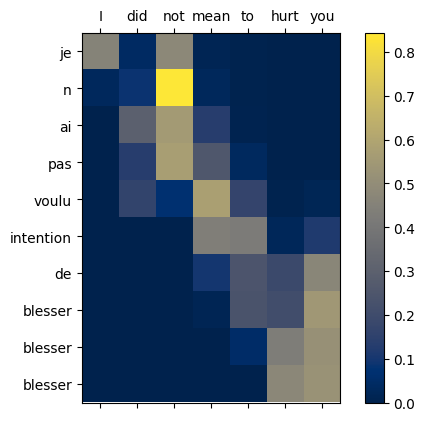

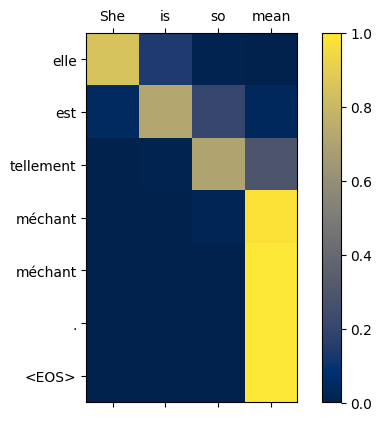

In [25]:
attentions_test = [
        'I did not mean to hurt you',
        'She is so mean',
    ]

for elt in attentions_test:
        model.attention_viz(elt)